In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from NeighbourClustering import *
import random
import pandas as pd
np.random.seed(1234)

## Parameters
N = 64
T = 200
c = 0.6  # 0.4   # 0.7
r = 1.4 # 0.5  # 0.7
p_loss = 0.5

# Analysis of the top/bottom Quantile
Quantile = 0.1

In [2]:
test_import = ClusteringRateNeighbour_import(np.ones((2,2)))

test_import.mean()

1.0

In [3]:
def Flattened_to_2DIndex(Array, n):
    '''
    Array: 1d enumeration of a previously n x n shaped array
    n: integer with len(Array) == n*n
    '''
    assert(len(Array) == n*n)
    i_index = (Array/n).astype(int)
    j_index = Array%n
    output = np.empty((n*n,2))
    output[:,0] = i_index
    output[:,1] = j_index
    return(output)



def Sample_Agent_B(N_agents, Indices_A, CircularBoundary = True):
    '''
    N_agents: integer (number of agents)
    Indices_A: 2d integer array (kth row of this array gives the x/y coordinates of agent k)
    '''
    
    # create 2d enumeration and flatten it
    Enumeration = np.arange(0,N_agents*N_agents).reshape((N_agents,N_agents))
    FlatEnumeration = Enumeration.flatten()
    
    # transform the flattened enumeration to (i,j) indices of the 2d map
    indices = Flattened_to_2DIndex(FlatEnumeration, N_agents)

    # Do we need to take "periodic" boundary conditions into account?
    if CircularBoundary: # top and bottom and left/right margin are neighbours
        ListIndices_Neighbours_A = [( Indices_A + [1,0])%N_agents,
                                        ( Indices_A + [-1,0])%N_agents,
                                        ( Indices_A + [0,1])%N_agents,
                                        ( Indices_A + [0,-1])%N_agents
                                   ]
        
    else: # Calculate the L1 Distances from the Indices of A
        Norm  = (abs(indices - Indices_A)).sum(axis = 1)
        Norm.reshape((N_agents,N_agents))
    # Safety check
    #ax = sns.heatmap(Norm.reshape((N_agents,N_agents)), linewidth=0.5)
    #plt.title("Distances")
    #plt.show()
    
    # Now create a list of only those indices that are exactly 1 distance away from A
        ListIndices_Neighbours_A = list(indices[Norm == 1])
    
    return(ListIndices_Neighbours_A)
    
    

In [4]:
Sample_Agent_B(N_agents = N, Indices_A = np.array([0,0]).astype(int))

[array([1, 0]), array([63,  0]), array([0, 1]), array([ 0, 63])]

In [5]:
AgentsTimeSeries = np.ones((N,N,T+1))


Agents = np.ones((N,N))
AgentsTimeSeries[:,:,0] = Agents
#ax = sns.heatmap(Agents, linewidth=0.5)
#plt.show()

cluster_top_timeseries = list()
cluster_bottom_timeseries = list()


for t in range(T):  # time units
    
    Contracts = list()
    Distances = list()
    
    for n in range(N*N): # time steps
        
        
        
        # A has the risk and wants to buy insurance
        i_A = np.random.randint(0,N)
        j_A = np.random.randint(0,N)
        
        # Wealth of A and associated cost/gain and maximum Fee
        w_A = Agents[i_A,j_A]
        G = r*w_A
        C = c*w_A
        F_max = w_A - ((w_A + G)**0.5) * ((w_A-C)**0.5)

        
        
        # Neighbourhood of A
        Neighbourhood = Sample_Agent_B(N_agents = N, 
                                       Indices_A = np.array([i_A,j_A]).astype(int))
        Neighbourhood_Offers = dict() # store the F_min offer of each neighbour
        Neighbourhood_Coordinates = dict() # store the coordinates/indices of neighbours
        Neighbours = 0 # enumeration of the neighbours for dict
        for Agent in Neighbourhood:
            i_B, j_B = Agent.astype(int)
            w_B = Agents[i_B, j_B]
            F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.
            Neighbourhood_Coordinates[Neighbours] = Agent
            Neighbourhood_Offers[Neighbours] = F_min
            Neighbours += 1
        
        # Identify best offer:
        B = min(Neighbourhood_Offers, key=Neighbourhood_Offers.get)
        i_B, j_B = Neighbourhood_Coordinates[B].astype(int)
        w_B = Agents[i_B, j_B]
        F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.

        '''
        print("###########")
        print("A",i_A, j_A)
        print("Positions", Neighbourhood_Coordinates)
        print("Offers", Neighbourhood_Offers)
        print("B", B)
        '''
        
        # Now Gamble
        p = np.random.uniform(0,1)
        win = p>p_loss
        
        if (F_min >= F_max) or (w_B <= C): 
            # B demands more than A is willing to pay:
            # no contract
            
            if win:
                Agents[i_A, j_A] *= (1+r)
            else:
                Agents[i_A,j_A] *= (1-c)
                
                
        elif F_min < F_max and (w_B > C):
            # make a contract at midway fee
            F = 0.5*(F_min + F_max) 
            
            Agents[i_A,j_A] -= F 
            
            
            Contracts += [(i_A, j_A, i_B, j_B)]  # record the signed contract
            #print(Contracts[-1])
            #print(F_min, F, F_max)
            #print(i_A, j_A, i_B, j_B)
            #print("\n")
            if win:
                Agents[i_B, j_B] += (F +  G)
            else:
                Agents[i_B, j_B] += (F-C)
            

    
    
    print("Time unit", t)
    print("Mean", np.mean(Agents))
    print("Median", np.median(Agents))
    #ax = sns.heatmap(np.log(Agents), linewidth=0.5)
    #ax = sns.heatmap(Agents>np.quantile(Agents,0.9), linewidth=0.5)  # Plot the extreme few %
    
    # Clustering    
    cluster_top_timeseries += [ClusteringRateNeighbour_import(Agents>np.quantile(Agents,1-Quantile)).mean()]
    cluster_bottom_timeseries += [ClusteringRateNeighbour_import(Agents<=np.quantile(Agents,Quantile)).mean()]
    
    
    
    # now plot the contracts of this time unit
    print("Number of contracts", len(Contracts))
    
    #for Indices in Contracts:
        #i1, j1, i2, j2 = Indices
        #print([j1,i1], [j2,i2])
        #plt.plot([j1+0.5,j2+0.5], [i1+0.5,i2+0.5], c = "yellow", alpha =0.8)
    #i1, j1, i2, j2 = Contracts[-1]
    #print([j1,i1], [j2,i2])
    #plt.plot([j1+0.5,j2+0.5], [i1+0.5,i2+0.5], c = "white")
    
    
    #plt.show()
    #print("Mean Distance for Contract", np.mean(np.array(Distances)))
    print("\n")
    
    AgentsTimeSeries[:,:,t+1] = Agents

Time unit 0
Mean 1.504160457573807
Median 1.0
Number of contracts 3677


Time unit 1
Mean 2.2692930883946105
Median 1.0
Number of contracts 3478


Time unit 2
Mean 3.129151263933079
Median 1.071140143158029
Number of contracts 3466


Time unit 3
Mean 4.568658542211236
Median 1.1317461109849098
Number of contracts 3445


Time unit 4
Mean 8.90713089606882
Median 1.2169217956018175
Number of contracts 3437


Time unit 5
Mean 13.072233387815675
Median 1.3492490530210048
Number of contracts 3479


Time unit 6
Mean 17.385717464636077
Median 1.5045390737621331
Number of contracts 3472


Time unit 7
Mean 37.63778104111789
Median 1.6928890173793716
Number of contracts 3495


Time unit 8
Mean 51.555447350654646
Median 1.8981025385560744
Number of contracts 3511


Time unit 9
Mean 43.94804816482748
Median 2.1158246976693826
Number of contracts 3488


Time unit 10
Mean 66.49232554406157
Median 2.3665212020786726
Number of contracts 3515


Time unit 11
Mean 67.86943889461946
Median 2.69014691350841

Median 2683790727812.659
TA of EV player 0.0172181975945747


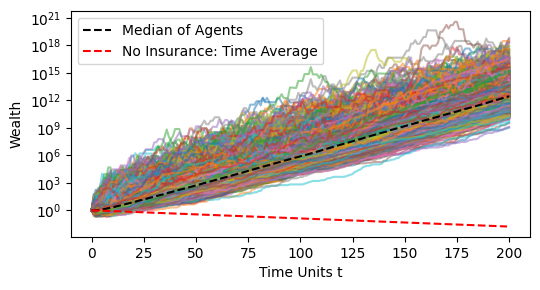

In [35]:
fig, ax = plt.subplots(1,1, figsize = (5.5,3))
for i in range(N):
    for j in range(N):
        ax.semilogy(AgentsTimeSeries[i,j,:], alpha = 0.5)
        
medians = list()
for t in range(T+1):
    medians  += [np.median(AgentsTimeSeries[:,:,t])]
print("Median",medians[-1])     # 1.659e-13
ax.semilogy(medians, c = "k", linestyle= "--", label="Median of Agents")
ax.set_xlabel("Time Units t")
ax.set_ylabel("Wealth")
#ax.semilogy([0,T],[1,1], c="k")

# Expectation

TA = np.ones(T)
TA =  ((1-c)**(p_loss) * (1+r)**(1-p_loss))**np.arange(T)
ax.semilogy(TA, c="red", linestyle = "--", label="No Insurance: Time Average")
plt.legend()
print("TA of EV player",TA[-1])
plt.tight_layout()
plt.savefig("Trajectories_N="+str(N)+".pdf",dpi = 100)
plt.show()
 

## Calculate Clustering

It should be possible to, for both of the top and bottom 10% quantile groups, calculate how many of them have a next neighbour inside this quantile. That's similar to the clustering coefficient. Then, compare that a permuation of ranked agents (CIs via bootstrapping). One can then transition from next-neighbours to the exponential decay of the distance (but still choose 4 agents for each to choose from!) and see if the clustering is persistent or not.

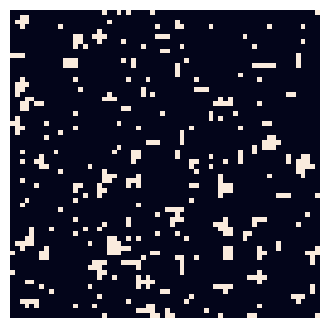

In [7]:
fig = plt.figure(figsize = (4,4))
TopDecile = Agents>np.quantile(Agents,0.9)
ax = sns.heatmap(TopDecile, linewidth=0.,  # Plot the upper few %
                 cbar=False)  # colour bar on the right
ax.tick_params(left=False, bottom=False,labelleft = False , 
                labelbottom = False) ## other options are right and top
plt.savefig("Top_Decile_N="+str(N)+".pdf",dpi = 100)
plt.show()

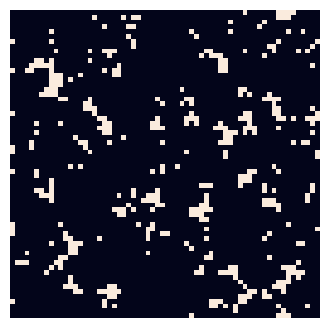

In [8]:
fig = plt.figure(figsize = (4,4))

BottomDecile = Agents<=np.quantile(Agents,0.1)
ax = sns.heatmap(BottomDecile, linewidth=0.,  # Plot the upper few %
                 cbar=False)  # colour bar on the right
ax.tick_params(left=False, bottom=False,labelleft = False , 
                labelbottom = False) ## other options are right and top
plt.savefig("Bottom_Decile_N="+str(N)+".pdf",dpi = 100)
plt.show()

In [9]:
test_bottom = ClusteringRateNeighbour_import(BottomDecile)
test_top = ClusteringRateNeighbour_import(TopDecile)

test_bottom.mean(), test_top.mean()

(0.7902439024390244, 0.7780487804878049)

### Now upper and lower half

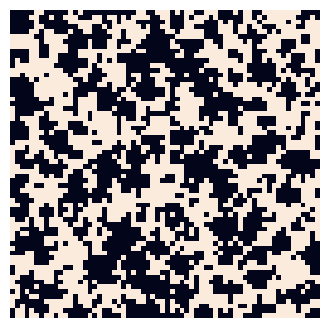

In [10]:
fig = plt.figure(figsize = (4,4))
ax = sns.heatmap(Agents < np.median(Agents),
                 linewidth=0.,  # Plot the upper few %
                 cbar=False)  # colour bar on the right
ax.tick_params(left=False, bottom=False,labelleft = False , 
                labelbottom = False) ## other options are right and top
plt.savefig("Top_Half_N="+str(N)+".pdf",dpi = 100)
plt.show()

### Clustering of Random Ensembles

Just create many shuffled matrices of the same shape and calculate their clustering coefficient to get an expected value and CIs for the Null-Hypothesis "there is no structure". Although this is also calculated below, it should be clear that the expected value should be the same for both of these groups.

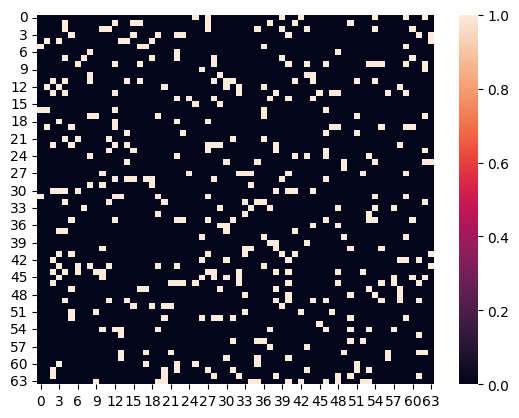

0.3829268292682927

In [11]:
RandomMatrix = np.random.uniform(size = (N,N) )
#sns.heatmap(RandomMatrix, linewidth = 0.)
#plt.show()
RandomMatrix = RandomMatrix <= np.quantile(RandomMatrix,0.1)
sns.heatmap(RandomMatrix, linewidth = 0.)
plt.show()
ClusteringRateNeighbour_import(RandomMatrix).mean()

In [12]:
np.log(AgentsTimeSeries[:,:,T].max()), np.log(AgentsTimeSeries[:,:,T].min())

(43.222956130925326, 20.749520442643096)

In [13]:
# Real Time Series Values vs. their ranking via .argsort().argsort():
# results should be identical! Quantiles remain in the same position!

q = 0.08

n_Ens = 100

for t in range(5,100,20):
    Bottom_Clust = list()
    Top_Clust = list()
    Bottom_Clust2 = list()
    Top_Clust2 = list()
    
    for Ensemble in range(n_Ens):
        RandomMatrix =  np.random.permutation(np.log(AgentsTimeSeries[:,:,t]).flatten()).reshape((N,N)) #np.random.normal(size = (N,N) ) #

        RandomBottom = RandomMatrix <= np.quantile(RandomMatrix,q)
        Bottom_Clust += [ClusteringRateNeighbour_import(RandomBottom).mean()]

        RandomTop = RandomMatrix > np.quantile(RandomMatrix,1-q)
        Top_Clust += [ClusteringRateNeighbour_import(RandomTop).mean()]

        #print(np.log(np.quantile(RandomMatrix,0.1)), np.log(np.quantile(RandomMatrix,0.9)))

        
        RM2 = RandomMatrix.flatten().argsort().argsort().reshape(RandomMatrix.shape)
        RandomBottom2 = RM2 <= np.quantile(RM2,q)
        Bottom_Clust2 += [ClusteringRateNeighbour_import(RandomBottom2).mean()]

        RandomTop2 = RM2 > np.quantile(RM2,1-q)
        Top_Clust2 += [ClusteringRateNeighbour_import(RandomTop2).mean()]

        
        
        
        
    Bottom_Clust = np.array(Bottom_Clust)
    Top_Clust = np.array(Top_Clust)
    print("\n",t,"\n",np.round(np.array([np.array(Bottom_Clust).mean(),np.array(Bottom_Clust).std(),
           np.array(Top_Clust).mean(),np.array(Top_Clust).std()]),2),"\n",
         np.round(np.array([np.array(Bottom_Clust2).mean(),np.array(Bottom_Clust2).std(), # here: argsort() index
           np.array(Top_Clust2).mean(),np.array(Top_Clust2).std()]),2))
    print(len(ClusteringRateNeighbour_import(RandomTop)), len(ClusteringRateNeighbour_import(RandomBottom)))


 5 
 [0.29 0.04 0.28 0.03] 
 [0.29 0.04 0.28 0.03]
328 328

 25 
 [0.28 0.03 0.28 0.03] 
 [0.28 0.03 0.28 0.03]
328 328

 45 
 [0.28 0.03 0.29 0.03] 
 [0.28 0.03 0.29 0.03]
328 328

 65 
 [0.28 0.03 0.29 0.03] 
 [0.28 0.03 0.29 0.03]
328 328

 85 
 [0.29 0.04 0.29 0.03] 
 [0.29 0.04 0.29 0.03]
328 328


In [14]:
np.quantile(RandomMatrix,q),np.quantile(RandomMatrix,1-q), np.median(RandomMatrix)

(8.858935323459265, 15.559491449299422, 11.386792391083745)

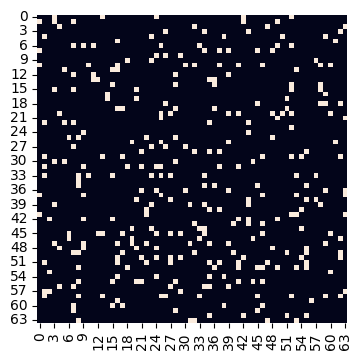

In [15]:
fig = plt.figure(figsize = (4,4))
sns.heatmap(RandomTop,linewidth = 0.,  # Plot the upper few %
                 cbar=False)  # colour bar on the right
ax.tick_params(left=False, bottom=False,labelleft = False ,labelbottom = False) ## other options are right and top
plt.savefig("Random_Top_10%_N="+str(N)+".pdf",dpi = 100)
plt.show()

#### THEORY
Via Binomial-like random variable X with probability q and 4 neighbour slots: 
$$ ClusteringRate = 1- P(X=0) = 1-(1-q)^4  $$ 

In [16]:
Binomial_Pred = 1-(1-Quantile)**4
print(Binomial_Pred)

0.3439


In [17]:
nr = 1000
q = 0.08
M = np.random.normal(0,1,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),Quantile)).mean())

M = np.random.pareto(1,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),Quantile)).mean())

M = np.random.poisson(1000,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),Quantile)).mean())

M = np.random.logistic(0,1,(nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),Quantile)).mean())

M = np.random.standard_cauchy((nr,nr))
print(ClusteringRateNeighbour_import(M<np.quantile(M.flatten(),Quantile)).mean())


0.34242
0.3451
0.33845750368173655
0.34095
0.3467


In [18]:
n_Ens = 1000
Bottom_Clust = list()
Top_Clust = list()

for Ensemble in range(n_Ens):
    RandomMatrix =  np.random.permutation(AgentsTimeSeries[:,:,-1].flatten()).reshape((N,N)) #np.random.normal(size = (N,N) ) #

    RandomBottom = RandomMatrix <= np.quantile(RandomMatrix,0.1)
    Bottom_Clust += [ClusteringRateNeighbour_import(RandomBottom).mean()]
    
    RandomTop = RandomMatrix > np.quantile(RandomMatrix,0.9)
    Top_Clust += [ClusteringRateNeighbour_import(RandomTop).mean()]
    
    #print(np.log(np.quantile(RandomMatrix,0.1)), np.log(np.quantile(RandomMatrix,0.9)))
    
Bottom_Clust = np.array(Bottom_Clust)
Top_Clust = np.array(Top_Clust)
Top_Clust.mean(), Bottom_Clust.mean()

(0.3445073170731707, 0.3450463414634146)

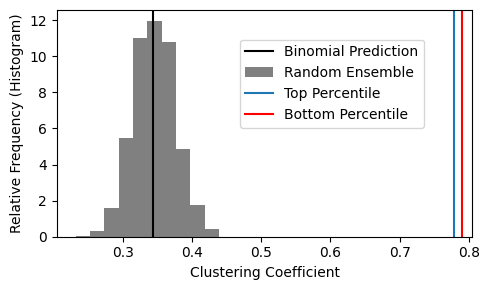

In [19]:
fig = plt.figure(figsize = (5,3))
plt.axvline(Binomial_Pred, c="k", label="Binomial Prediction")
plt.hist(Top_Clust, color="grey", density = True,label="Random Ensemble")
plt.axvline(test_top.mean(), label="Top Percentile")
plt.axvline(test_bottom.mean(), c="red", label="Bottom Percentile")
plt.legend(bbox_to_anchor=(0.9, 0.9))
plt.xlabel("Clustering Coefficient")
plt.ylabel("Relative Frequency (Histogram)")
plt.tight_layout()
plt.savefig("Histrogram_N="+str(N)+".pdf",dpi = 100)
plt.show()

In [20]:
test_top.mean(), test_bottom.mean()

(0.7780487804878049, 0.7902439024390244)

In [21]:
Top_Clust.mean() + Top_Clust.std()

0.3749899016018469

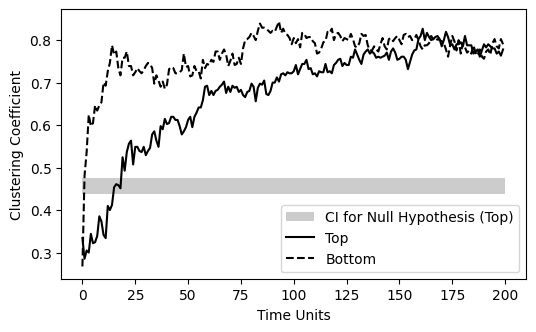

In [22]:
# Top_Clust
fig = plt.figure(figsize = (6,3.5))
plt.axvspan(xmin= 0 ,xmax = len(cluster_top_timeseries), 
            ymin=Top_Clust.mean() - Top_Clust.std(), 
            ymax=Top_Clust.mean() + Top_Clust.std(), 
            alpha = 0.4, facecolor="grey",label="CI for Null Hypothesis (Top)")
# Bottom_Clust
#plt.axvspan(xmin= 0 ,xmax = len(cluster_top_timeseries), 
#            ymin=Bottom_Clust.mean() - Bottom_Clust.std(), 
#            ymax=Bottom_Clust.mean() + Bottom_Clust.std(), 
#            alpha = 0.4, facecolor="red",label="CI for Null Hypothesis (Bottom)")
plt.plot(cluster_top_timeseries, label="Top", c="k",)
plt.plot(cluster_bottom_timeseries,"--", label="Bottom", c="k")
plt.xlabel("Time Units")
plt.ylabel("Clustering Coefficient")
plt.legend()
plt.savefig("10%_quantiles_N="+str(N)+"_T="+str(T)+"_c="+str(c)+"_r="+str(r)+"_p_loss="+str(p_loss)+".pdf", dpi = 100)
plt.show()

## Questions:

- How stable is the position of an agent?
- How much do the members of the top/bottom percentile fluctuate? (Spearman's rank correlation coefficient, Friedman test?)
- which wealth distribution arises?


(array([   7.,  295., 1075., 1243.,  824.,  421.,  154.,   53.,   16.,
           8.]),
 array([20.74952044, 22.99686401, 25.24420758, 27.49155115, 29.73889472,
        31.98623829, 34.23358186, 36.48092542, 38.72826899, 40.97561256,
        43.22295613]),
 <BarContainer object of 10 artists>)

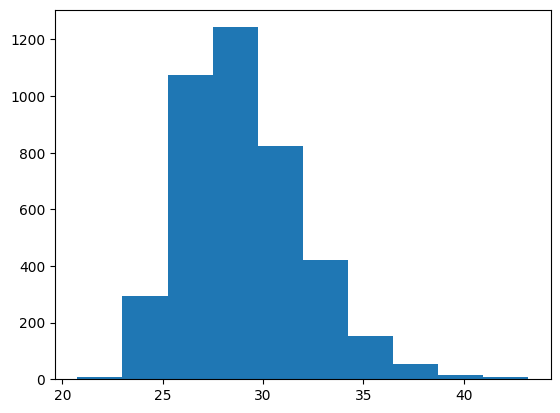

In [23]:
plt.hist(np.log(AgentsTimeSeries[:,:,-1].flatten()))

In [24]:
AgentsTimeSeries.shape

(64, 64, 201)

In [25]:
DF = pd.DataFrame({})

for t in range(1,AgentsTimeSeries.shape[2]):
    Agents_t = AgentsTimeSeries[:,:,t].flatten()
    DF["TU "+str(t)] = Agents_t  # TU = Time Unit

/tmp/ipykernel_2234723/3248624163.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DF["TU "+str(t)] = Agents_t  # TU = Time Unit
/tmp/ipykernel_2234723/3248624163.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DF["TU "+str(t)] = Agents_t  # TU = Time Unit
/tmp/ipykernel_2234723/3248624163.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

In [26]:
DF_Small = pd.DataFrame({})

for t in range(10, AgentsTimeSeries.shape[2],10):
    DF_Small["TU_"+str(t)] =  DF["TU "+str(t)].copy()

In [27]:
DF_Small.corr(method='spearman').round(2)

,TU_10,TU_20,TU_30,TU_40,TU_50,TU_60,TU_70,TU_80,TU_90,TU_100,TU_110,TU_120,TU_130,TU_140,TU_150,TU_160,TU_170,TU_180,TU_190,TU_200
TU_10,1.00,0.68,0.53,0.43,0.38,0.33,0.30,0.27,0.24,0.22,0.20,0.18,0.18,0.16,0.16,0.17,0.16,0.15,0.15,0.14
TU_20,0.68,1.00,0.79,0.65,0.56,0.48,0.43,0.40,0.36,0.33,0.30,0.28,0.26,0.23,0.22,0.23,0.22,0.21,0.20,0.18
TU_30,0.53,0.79,1.00,0.83,0.71,0.61,0.54,0.49,0.45,0.41,0.37,0.34,0.32,0.29,0.28,0.28,0.26,0.25,0.23,0.21
TU_40,0.43,0.65,0.83,1.00,0.86,0.75,0.67,0.60,0.55,0.50,0.46,0.43,0.40,0.37,0.36,0.35,0.32,0.30,0.28,0.26
TU_50,0.38,0.56,0.71,0.86,1.00,0.88,0.79,0.71,0.65,0.59,0.53,0.49,0.46,0.43,0.41,0.40,0.38,0.35,0.33,0.31
TU_60,0.33,0.48,0.61,0.75,0.88,1.00,0.89,0.80,0.73,0.66,0.61,0.57,0.53,0.49,0.47,0.46,0.43,0.40,0.37,0.35
TU_70,0.30,0.43,0.54,0.67,0.79,0.89,1.00,0.90,0.81,0.74,0.68,0.63,0.58,0.55,0.52,0.50,0.47,0.44,0.41,0.39
TU_80,0.27,0.40,0.49,0.60,0.71,0.80,0.90,1.00,0.91,0.83,0.76,0.70,0.66,0.62,0.58,0.56,0.52,0.49,0.46,0.44
TU_90,0.24,0.36,0.45,0.55,0.65,0.73,0.81,0.91,1.00,0.91,0.84,0.78,0.72,0.68,0.63,0.61,0.57,0.53,0.50,0.48
TU_100,0.22,0.33,0.41,0.50,0.59,0.66,0.74,0.83,0.91,1.00,0.92,0.86,0.80,0.75,0.70,0.67,0.63,0.58,0.55,0.52


#### Significance Test

In [28]:
Spearman = DF.corr(method = "spearman").to_numpy()
Spearman.round(1)

array([[1. , 0.7, 0.6, ..., 0.1, 0.1, 0.1],
       [0.7, 1. , 0.9, ..., 0.1, 0.1, 0.1],
       [0.6, 0.9, 1. , ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 1. , 1. , 1. ],
       [0.1, 0.1, 0.1, ..., 1. , 1. , 1. ],
       [0.1, 0.1, 0.1, ..., 1. , 1. , 1. ]])

In [29]:
n_obs = len(AgentsTimeSeries[:,:,-1].flatten())
n_obs
t = Spearman * ( (n_obs - 2 )/(1 - Spearman**2) )**0.5  # Test significance via student's t
t

/tmp/ipykernel_2234723/643327252.py:3: RuntimeWarning: divide by zero encountered in divide
  t = Spearman * ( (n_obs - 2 )/(1 - Spearman**2) )**0.5  # Test significance via student's t


array([[         inf,  69.25270219,  51.88877604, ...,   3.53338378,
          3.6245534 ,   3.68176557],
       [ 69.25270219,          inf, 106.66908471, ...,   3.9563224 ,
          4.13700817,   4.17834339],
       [ 51.88877604, 106.66908471,          inf, ...,   5.8231666 ,
          5.99121937,   6.02312875],
       ...,
       [  3.53338378,   3.9563224 ,   5.8231666 , ...,          inf,
        623.11920069, 437.88472553],
       [  3.6245534 ,   4.13700817,   5.99121937, ..., 623.11920069,
                 inf, 631.79631064],
       [  3.68176557,   4.17834339,   6.02312875, ..., 437.88472553,
        631.79631064,          inf]])

Ignore the inf on diagonal: that is trivial because or Spearman-r = 1. Results are extremely high t-statistics and therefore highly significant, but that may be an effect due to the large n (~16.000).

#### Higher Diagonals

The diagonal of Spearman-r has always 1. Let's compute the mean of the diagonals beyond the main diagonal.

In [30]:
Offsets = np.arange(1,Spearman.shape[0]).astype(int)
Means = []
Stds = []


for offset in Offsets:
    Means += [np.mean(np.diagonal(Spearman, offset=offset))]
    Stds += [np.std(np.diagonal(Spearman, offset=offset))]

Means = np.array(Means)
Stds = np.array(Stds)

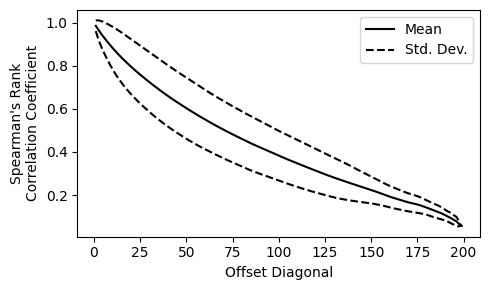

In [31]:
fig = plt.figure(figsize = (5,3))
plt.plot(Offsets, Means, c="k", label="Mean")
plt.plot(Offsets, Means+Stds, "--",c="k", label="Std. Dev.")
plt.plot(Offsets, Means-Stds, "--",c="k")
plt.xlabel("Offset Diagonal")
plt.ylabel("Spearman's Rank\nCorrelation Coefficient")
plt.legend()
plt.tight_layout()
plt.savefig("SpearmanRankCorr_N="+str(N)+".pdf", dpi = 100)
plt.show()